# MovieLens Exploratory Dataset
**Purpose:** 

This notebook explores the distribution of input movielens datasets and preprocesses it for the RecSys

**Methodology:**

The notebook assumes input from the [MovieLens Dataset](https://grouplens.org/datasets/movielens/). It will explore the dataset using basic statistics and explores properties of hidden clusters. It outputs a processed dataset of the following format: 

**Author:**

Prajna Soni (@prajnasoni)

In [16]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
#import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
#from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.mixture import GaussianMixture
import logging


%matplotlib inline

In [19]:
# Load MovieLens dataset
#from lenskit.datasets import ML100K
#movielens = ML100K('ml-100k')

movies = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/movies.csv")
ratings = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/ratings.csv")
links = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/links.csv") #links to IMDB and themovieDB
tags = pd.read_csv("/Users/pvs262/Documents/rec-sys-dynamics/datasets/movielens-small/tags.csv")

In [20]:
# Timestamp is the timestamp since January 1, 1970 in seconds
# Reduce dimensionality of time so it starts from earliest time as 0 seconds
min_t = ratings['timestamp'].min()
ratings['timestamp'] = ratings['timestamp']-min_t
tags['timestamp'] = tags['timestamp'] - min_t

In [21]:
# MOVIELENS DATASET CLASS - easy access functions to process movielens dataset
class movielens:
    
     # constructor taking in dataset (genre_ratings), number of maximum clusters
    def __init__(self, movies, ratings, links, tags):
        
        # assign input rating matrix
        self.movies = movies
        self.ratings = ratings
        self.links = links
        self.tags = tags
        
        self.get_dummy_genres()
        
        # Enable logging
        logger = logging.getLogger(__name__)
        
    def __str__(self):
        return 'MovieLens Dataset'
    
    # Function to return list of strings of genres in MovieLens dataset
    def get_genres(self):
        return self.genres
        
    # Function to return dataframe of user (rows) and movie (columns) ratings - a user-item interaction matrix
    def UserItem(self):
        self.UI_matrix = self.ratings.merge(movies,on='movieId', how='left')
        self.UI_matrix = self.UI_matrix.pivot_table(index='userId',columns='title',values='rating')
        self.UI_matrix = self.UI_matrix.fillna(0)
        return self.UI_matrix 
    
    # Function to get the genre ratings
    def UserGenreRatings(self):
        self.genre_ratings = pd.DataFrame()
        for genre in self.genres():        
            genre_movies = self.movies[self.movies['genres'].str.contains(genre)]
            avg_genre_votes_per_user = self.ratings[self.ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
            self.genre_ratings = pd.concat([self.genre_ratings, avg_genre_votes_per_user], axis=1)    
        self.genre_ratings = genre_ratings.fillna(0)
        self.genre_ratings.columns = self.genres()
        return self.genre_ratings

    # Function to get the number of ratings per genre per user
    def UserGenreCounts(self):
        self.genre_counts = pd.DataFrame()
        for genre in self.genres:        
            genre_movies = self.movies[self.movies['genres'].str.contains(genre) ]
            genre_counts_per_user = self.ratings[self.ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].count()
            self.genre_counts = pd.concat([self.genre_counts, genre_counts_per_user], axis=1).fillna(0)   
        self.genre_counts.columns = self.genres
        return self.genre_counts

    # Function to count total number of movies a user has rated
    def TotalUserRatings(self):
        total_user_ratings = self.ratings.groupby(['userId']).count().drop(columns = ['movieId','timestamp'], axis = 1)
        total_user_ratings.columns = ['total_ratings']
        return total_user_ratings

    # Function to split movie genres into dummy variables
    def get_dummy_genres(self):
        genres_list = self.movies['genres'].str.split(pat='|') # convert string to list of string
        self.movies2 = pd.concat([movies.drop(['genres','title'],axis=1), genres_list.str.join('|').str.get_dummies()], axis=1) # concatenate dummy variables df of genres
        self.genres = self.movies2.columns.tolist()[1:]
        return self.movies2

# Distribution of Dataset

(0.0, 5.0)

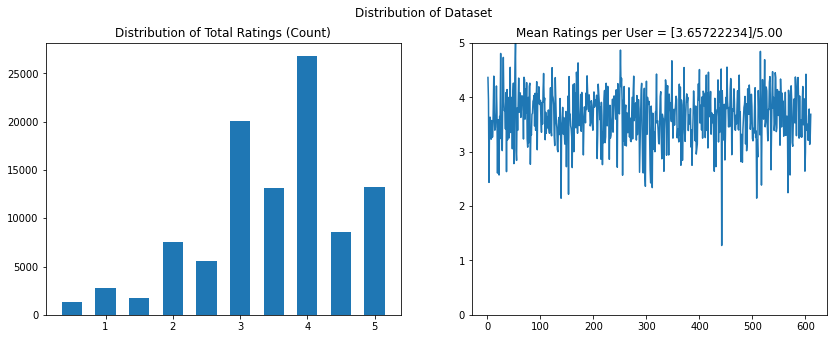

In [112]:
rating_count = ratings['rating'].value_counts().sort_values(ascending=False)
avg_user = ratings.drop(columns = ['movieId','timestamp'], axis = 1).groupby(['userId']).mean()

rating_range = [0,1,2,3,4,5]
avg_movie = ratings.drop(columns = ['userId','timestamp'], axis = 1).groupby(['movieId']).mean()
avg_movie = pd.cut(avg_movie['rating'], bins=rating_range, include_lowest=True).value_counts(sort=False)

fig, plts = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_figheight(5)
fig.suptitle('Distribution of Dataset')
plts[0].set_title('Distribution of Total Ratings (Count)',fontsize=12)
plts[0].bar(x=rating_count.index,height=rating_count.values, width=0.3)

plts[1].set_title('Mean Ratings per User = ' + str(avg_user.mean().values)+'/5.00',fontsize=12)
plts[1].plot(avg_user.index,avg_user.values)
plts[1].set_ylim(0,5)


<AxesSubplot:title={'center':'Distribution of Mean Movie Ratings (Count)'}>

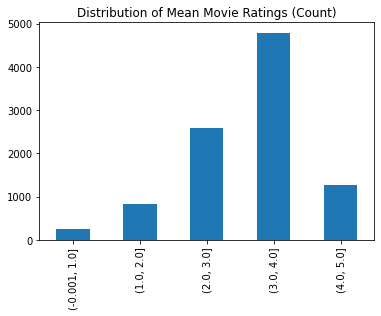

In [113]:
avg_movie.plot.bar(title='Distribution of Mean Movie Ratings (Count)')

# Dimensionality Reduction using SVD

In [22]:
# Create MovieLens Object with DFs from loaded CSVs
data = movielens(movies, ratings, links, tags)

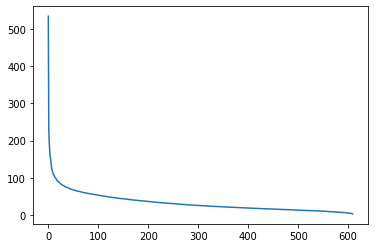

In [23]:
# Decomposition of Singular Values from SVD for Dimensionality Reduction
SVD_full =  TruncatedSVD(n_components = len(data.UserItem()))
UI = pd.DataFrame(SVD_full.fit_transform(data.UserItem()))
UI.index += 1

# Plot Singular Value Decomposition 
plt.plot(SVD_full.singular_values_)
plt.show()

In [24]:
UI_temp = pd.DataFrame()

for i in range(3):
    UI_temp = UI_temp.join(UI[i],how='right')
    
    
print(UI_temp)

             0          1          2
1    29.689183 -14.261496  -2.083147
2     3.135059   4.101575  -0.845611
3     0.724586  -0.479522   0.327516
4    17.294877 -12.540135   6.530831
5     6.097029  -5.338440  -9.279148
..         ...        ...        ...
606  59.473721 -16.737502  26.630153
607  20.832472 -11.700443  -6.971945
608  62.054063  -2.738936  -1.866859
609   4.050590  -3.187589  -7.596466
610  74.212318  46.753088  17.713731

[610 rows x 3 columns]


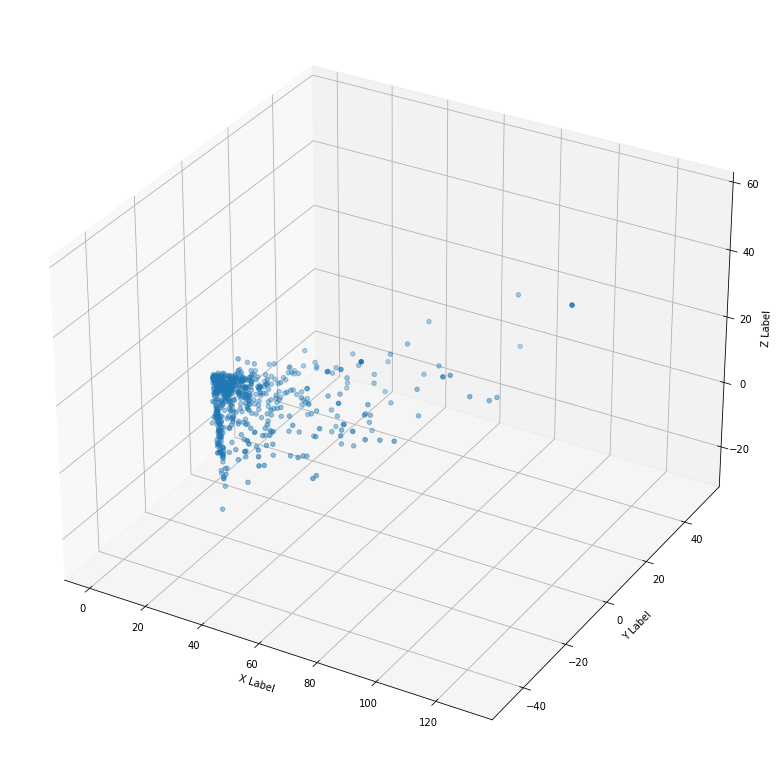

In [25]:
# Plot 2D and 3D scatter graphs of 2-feature and 3-feature reductions
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(14)
#twoD = fig.add_plot(211)

#twoD.scatter(UI_temp[0], UI_temp[1])
#twoD.set_xlabel('X Label')
#twoD.set_ylabel('Y Label')

threeD = fig.add_subplot(111, projection='3d')

threeD.scatter(UI_temp[0], UI_temp[1], UI_temp[2])

threeD.set_xlabel('X Label')
threeD.set_ylabel('Y Label')
threeD.set_zlabel('Z Label')

plt.show()

In [95]:
thriller = get_genre_ratings(ratings, movies, genres, genres)['Thriller']
horror = get_genre_ratings(ratings, movies, genres, genres)['Horror']
#type(thriller)
x = thriller.to_numpy()
y = horror.to_numpy()
#plt.scatter(x,y)
#type(plt)
#plt.show()

/Users/pvs262/Library/Python/3.8/lib/python/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


matplotlib.axes._subplots.AxesSubplot

# K-Means Clustering

In [26]:
# CLASS TO CLUSTER AND EVALUATE DATA
class data:

    # constructor taking in dataset (genre_ratings), number of maximum clusters
    def __init__(self, data):
        
        # assign input rating matrix
        self.data = data 
        
        # Enable logging
        logger = logging.getLogger(__name__)
        
    def __str__(self):
        return 'Data Object'
    
    # perform kmeans clustering for n clusters on data and return a dataframe with user and cluster number 
    def kmeans(self, n):
        
        if n is None:
            _logger.warning('Number of clusters not provided')
            return None
        
        km = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
        self.km_pred = km.fit_predict(self.data)
        self.km_pred = pd.DataFrame(self.km_pred, columns = ['cluster'])
        self.km_pred.index += 1 # adjust index to match userId
        #clustered_data = pd.concat([self.data, km_pred], axis=1)
        return self.km_pred
    
    # print graphs to evaluate kmeans clustering from 2 to n clusters using kmeans score, silhouette score and davies-bouldin score
    def kmeans_eval(self, n):
        
        if n is None:
            _logger.warning('Number of maximum clusters not provided')
            return None
        
        # variable scope limited to function
        km_scores= []
        km_silhouette = []
        db_score = []
        
        # calculate scores 
        for i in range(2,n+1):
            km = KMeans(n_clusters=i, random_state=0, max_iter=300).fit(self.data)
            km_pred = km.predict(self.data)

            #KM Score
            km_scores.append(-kmeans.score(self.data))

            #Silhouette Score
            km_silhouette.append(metrics.silhouette_score(self.data, km_pred))

            #Davies Bouldin Score
            # the average similarity measure of each cluster with its most similar cluster, 
            # where similarity is the ratio of within-cluster distances to between-cluster distances. 
            # Thus, clusters which are farther apart and less dispersed will result in a better score.
            db_score.append(metrics.davies_bouldin_score(self.data, km_pred))

        # plot graphs of evaluation metrics
        # ELBOW METHOD (optimal cluster at elbow in curve)
        plt.figure(figsize=(14,21))
        plt.subplot(3,1,1)
        plt.title("The elbow method for determining number of clusters",fontsize=16)
        plt.scatter(x=[i for i in range(2,n+1)],y=km_scores,s=150,edgecolor='k')
        plt.grid(True)
        plt.xlabel("Number of clusters",fontsize=14)
        plt.ylabel("K-means Score",fontsize=15)
        plt.xticks([i for i in range(2,n+1)],fontsize=14)
        plt.yticks(fontsize=15)
        
        # SILHOUETTE SCORE (silhouette score varies from [-1,1] with 1 meaning clearly defined clusters)
        plt.subplot(3,1,2)
        plt.title("The silhouette coefficient method for determining number of clusters (1 is ideal)",fontsize=16)
        plt.scatter(x=[i for i in range(2,n+1)],y=km_silhouette,s=150,edgecolor='k')
        plt.grid(True)
        plt.xlabel("Number of clusters",fontsize=14)
        plt.ylabel("Average Silhouette Score",fontsize=15)
        plt.ylim(-1,1)
        plt.xticks([i for i in range(2,n+1)],fontsize=14)
        plt.yticks(fontsize=15)
       
        # DAVIES-BOULDIN SCORE (lower score is better and means more disctinct clusters)
        plt.subplot(3,1,3)
        plt.title("The davies-bouldin coefficient method for determining number of clusters (0 is ideal)",fontsize=16)
        plt.scatter(x=[i for i in range(2,n+1)],y=db_score,s=150,edgecolor='k')
        plt.grid(True)
        plt.xlabel("Number of clusters")
        plt.ylabel("Davies-Bouldin Score")
        plt.ylim(bottom = 0)
        plt.xticks([i for i in range(2,n+1)],fontsize=14)
        plt.yticks(fontsize=15)
        
        plt.show()

    # perform GaussianMixture clustering for n clusters on data and return a dataframe with user and cluster number
    def gmm(self, n, covariance_type):
        
        if n is None:
            _logger.warning('Number of maximum clusters not provided')
            return None
        
        if covariance_type is None:
            _logger.warning('Covariance Type for Gaussian Mixture Model not provided')
            return None
        
        gmm = GaussianMixture(n_components=n, n_init=10, covariance_type=covariance_type, tol=1e-3, max_iter=500)
        self.gmm_pred = gmm.fit_predict(self.data)
        self.gmm_pred = pd.DataFrame(self.gmm_pred, columns = ['cluster'])
        self.gmm_pred.index += 1 # adjust index to match userId
        return self.gmm_pred
    
    # print graphs to evaluate kmeans clustering from 2 to n clusters using 
    def gmm_eval(self, n, covariance_type):
        
        if n is None:
            _logger.warning('Number of maximum clusters not provided')
            return None
        
        if covariance_type is None:
            _logger.warning('Covariance Type for Gaussian Mixture Model not provided')
            return None
        
        # variable scope limited to function
        gmm_aic = []
        gmm_bic = []
        gmm_scores = [] 
        
        # calculate scores 
        for i in range(2,n+1):
            gmm = GaussianMixture(n_components=i,n_init=10, covariance_type = covariance_type, tol=1e-3,max_iter=500).fit(self.data)
            
            # Akaike Information Criterion
            gmm_aic.append(gmm.aic(self.data))
            
            # Bayesian Information Criterion
            gmm_bic.append(gmm.bic(self.data))
            
            gmm_scores.append(gmm.score(self.data))
            
        # Plot the scores 
        plt.figure(figsize=(14,21))
        plt.subplot(3,1,1)
        #plt.title("The Gaussian Mixture model AIC for determining number of clusters, CT = "+covariance_type,fontsize=16)
        plt.scatter(x=[i for i in range(2,n+1)],y=np.log(gmm_aic),s=150,edgecolor='k')
        plt.grid(True)
        plt.xlabel("Number of clusters",fontsize=14)
        plt.ylabel("Log of Gaussian mixture AIC score",fontsize=15)
        plt.xticks([i for i in range(2,n+1)],fontsize=14)
        plt.yticks(fontsize=15)

        plt.subplot(3,1,2)
        #plt.title("The Gaussian Mixture model BIC for determining number of clusters, CT = "+covariance_type,fontsize=16)
        plt.scatter(x=[i for i in range(2,n+1)],y=np.log(gmm_bic),s=150,edgecolor='k')
        plt.grid(True)
        plt.xlabel("Number of clusters",fontsize=14)
        plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
        plt.xticks([i for i in range(2,n+1)],fontsize=14)
        plt.yticks(fontsize=15)
   
        plt.subplot(3,1,3)
        #plt.title("The Gaussian Mixture model scores for determining number of clusters, CT = "+covariance_type,fontsize=16)
        plt.scatter(x=[i for i in range(2,n+1)],y=gmm_scores,s=150,edgecolor='k')
        plt.grid(True)
        plt.xlabel("Number of clusters",fontsize=14)
        plt.ylabel("Gaussian mixture score",fontsize=15)
        plt.xticks([i for i in range(2,n+1)],fontsize=14)
        plt.yticks(fontsize=15)
        plt.show()


In [27]:
GR = data(UI_temp)

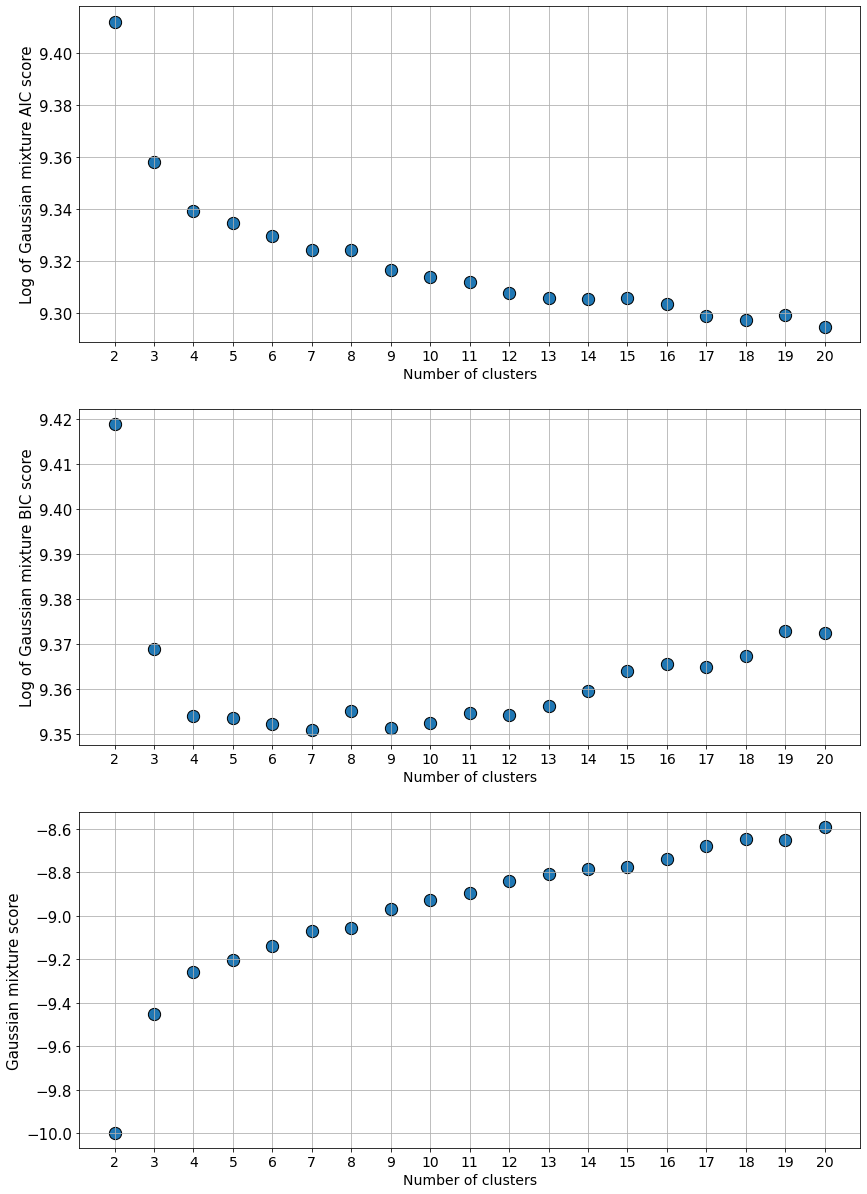

In [28]:
GR.gmm_eval(n=20,covariance_type="full")

In [29]:
# Test out 3D interactive plot 
clustered = UI_temp.join(GR.gmm(3, 'full'),how='left')

In [30]:
clustered

,0,1,2,cluster
1,29.689183,-14.261496,-2.083147,2
2,3.135059,4.101575,-0.845611,1
3,0.724586,-0.479522,0.327516,0
4,17.294877,-12.540135,6.530831,2
5,6.097029,-5.338440,-9.279148,0
...,...,...,...,...
606,59.473721,-16.737502,26.630153,2
607,20.832472,-11.700443,-6.971945,2
608,62.054063,-2.738936,-1.866859,2
609,4.050590,-3.187589,-7.596466,0


In [31]:
import plotly.express as px

UI_clus = px.scatter_3d(clustered, color='cluster')

UI_clus.show()

# Examine distribution of clusters 
cluster_count = predictions['cluster'].value_counts()
cluster_count.plot.bar(title='Distribution of Users in Clusters (Count)')

# Gaussian Mixture Modelling Clustering

In [128]:
# Assign features and target variable
X = genre_ratings
Y = predictions

In [132]:
# Train a decision tree to understand the definiing features separating the clusters 
# and understand how the entropy changes 

# We split the data into a training (80%) and testing (20%) dataset
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.20, random_state=0, stratify=Y)
#declare decision tree classifier classifiying based on entropy 
KMeans_Tree = DecisionTreeClassifier(max_depth =3, criterion ='entropy')
#train decision tree classifier on training data
KMeans_Tree.fit(train_X, train_Y)
#get predicted results for given test_X
KMeans_TreePred = KMeans_Tree.predict(test_X)
acc_score = metrics.accuracy_score(test_Y, KMeans_TreePred)
print(acc_score)
#metrics.confusion_matrix(test_Y, KMeans_TreePred)

0.9180327868852459


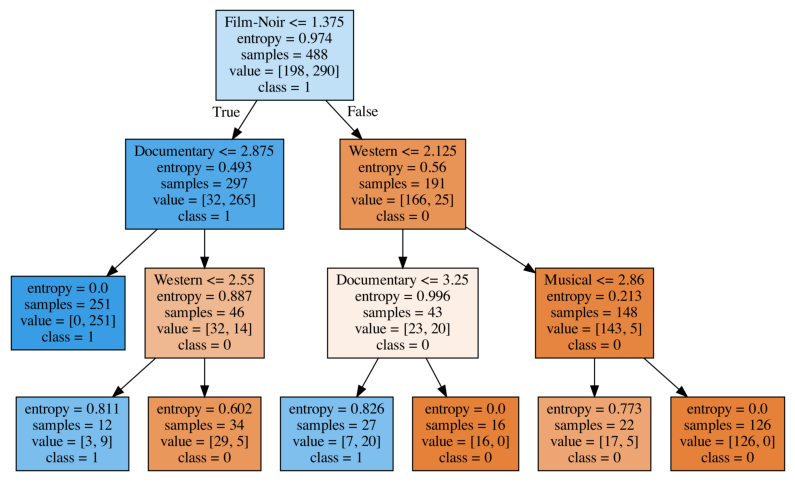

In [133]:
class_names = [str(int) for int in range(26)]
#Let's visualise the tree
tree.export_graphviz(KMeans_Tree, out_file = 'KMeans_Tree.dot', feature_names = X.columns, class_names = [str(int) for int in range(26)], filled = True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'KMeans_Tree.dot', '-o', 'KMeans_Tree.png', '-Gdpi=600'])

# Display in python
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('KMeans_Tree.png'))
plt.axis('off');
plt.show();